### BRDF Fitting
This file fits BRDF models for the Starlink v1.5 Chassis Deck, Starlink v1.5 Solar Array, and surface of the Earth for vegetation and ocean water.

1. Binomial models are fit to SpaceX BRDF data measured by ScatterWorks
2. Phong models are fit to BRDF data from the Cloud Absorption Radiometer sensor

In [1]:
# Imports
import numpy as np
import lumos.brdf.library
import lumos.brdf.tools
import lumos.plot
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [2]:
def plot_fit(ax, model, brdf_file):
    
    phi_in, theta_in, phi_out, theta_out, brdf = lumos.brdf.tools.read_brdf(brdf_file)

    incident_angles = np.unique(phi_in)
    for angle in incident_angles:
        # Plot measured data
        ax.semilogy(phi_out[phi_in == angle], brdf[phi_in == angle], 
                    '.', label = r"$\phi_{in}$ = " + f"{angle:0.1f}°")
        
        # Plot model data
        x = np.linspace(-90, 90, 400)
        ix, iy, iz = lumos.conversions.spherical_to_unit(np.deg2rad(angle), np.pi)
        ox, oy, oz = lumos.conversions.spherical_to_unit(np.deg2rad(x), 0)
        y = model((ix, iy, iz), (0, 0, 1), (ox, oy, oz))
        ax.semilogy(x, y, '-k')
    
    for angle in (10, 20, 30, 40, 50, 60, 70, 80):
        # Plot model data at intermediat angles
        # to show there is no overfitting
        x = np.linspace(-90, 90, 400)
        ix, iy, iz = lumos.conversions.spherical_to_unit(np.deg2rad(angle), np.pi)
        ox, oy, oz = lumos.conversions.spherical_to_unit(np.deg2rad(x), 0)
        y = model((ix, iy, iz), (0, 0, 1), (ox, oy, oz))
        ax.semilogy(x, y, '--k', alpha = 0.25)

In [3]:
def binomial_fit(brdf_file, n, m, l1, l2, d):
    N_params = n * m + n * (l2 - l1)

    def model(*params):
        B, C = lumos.brdf.tools.pack_binomial_parameters(n, m, l1, l2, *params)
        brdf = lumos.brdf.library.BINOMIAL(B, C, d, l1)
        return brdf
    
    optimal_params = lumos.brdf.tools.fit(
        brdf_file,
        model,
        bounds = (-1e3, 1e3),
        p0 = -1 * np.ones(N_params),
        clip = 1e-3)
    
    B, C = lumos.brdf.tools.pack_binomial_parameters(n, m, l1, l2, *optimal_params)
    return B, C

### Chassis

In [4]:
B, C = binomial_fit("../data/chassis_brdf.csv", n = 1, m = 2, l1 = -5, l2 = 5, d = 3.0)

print("B = ", np.array_str(B, precision = 3))
print("C = ", np.array_str(C, precision = 3))

chassis_brdf = lumos.brdf.library.BINOMIAL(B, C, d = 3.0, l1 = -5)

B =  [[  3.34  -98.085]]
C =  [[-999.996  867.605 1000.    1000.    -731.261  618.562 -294.06   269.251
  -144.855   75.196]]


### Solar Array

In [5]:
B, C = binomial_fit("../data/solar_array_brdf.csv", n = 1, m = 2, l1 = -3, l2 = 3, d = 3.0)

print("B = ", np.array_str(B, precision = 3))
print("C = ", np.array_str(C, precision = 3))

solar_array_brdf = lumos.brdf.library.BINOMIAL(B, C, d = 3.0, l1 = -3)

B =  [[  0.534 -20.41 ]]
C =  [[-527.681 1000.    -676.62   430.623 -175.816   57.881]]


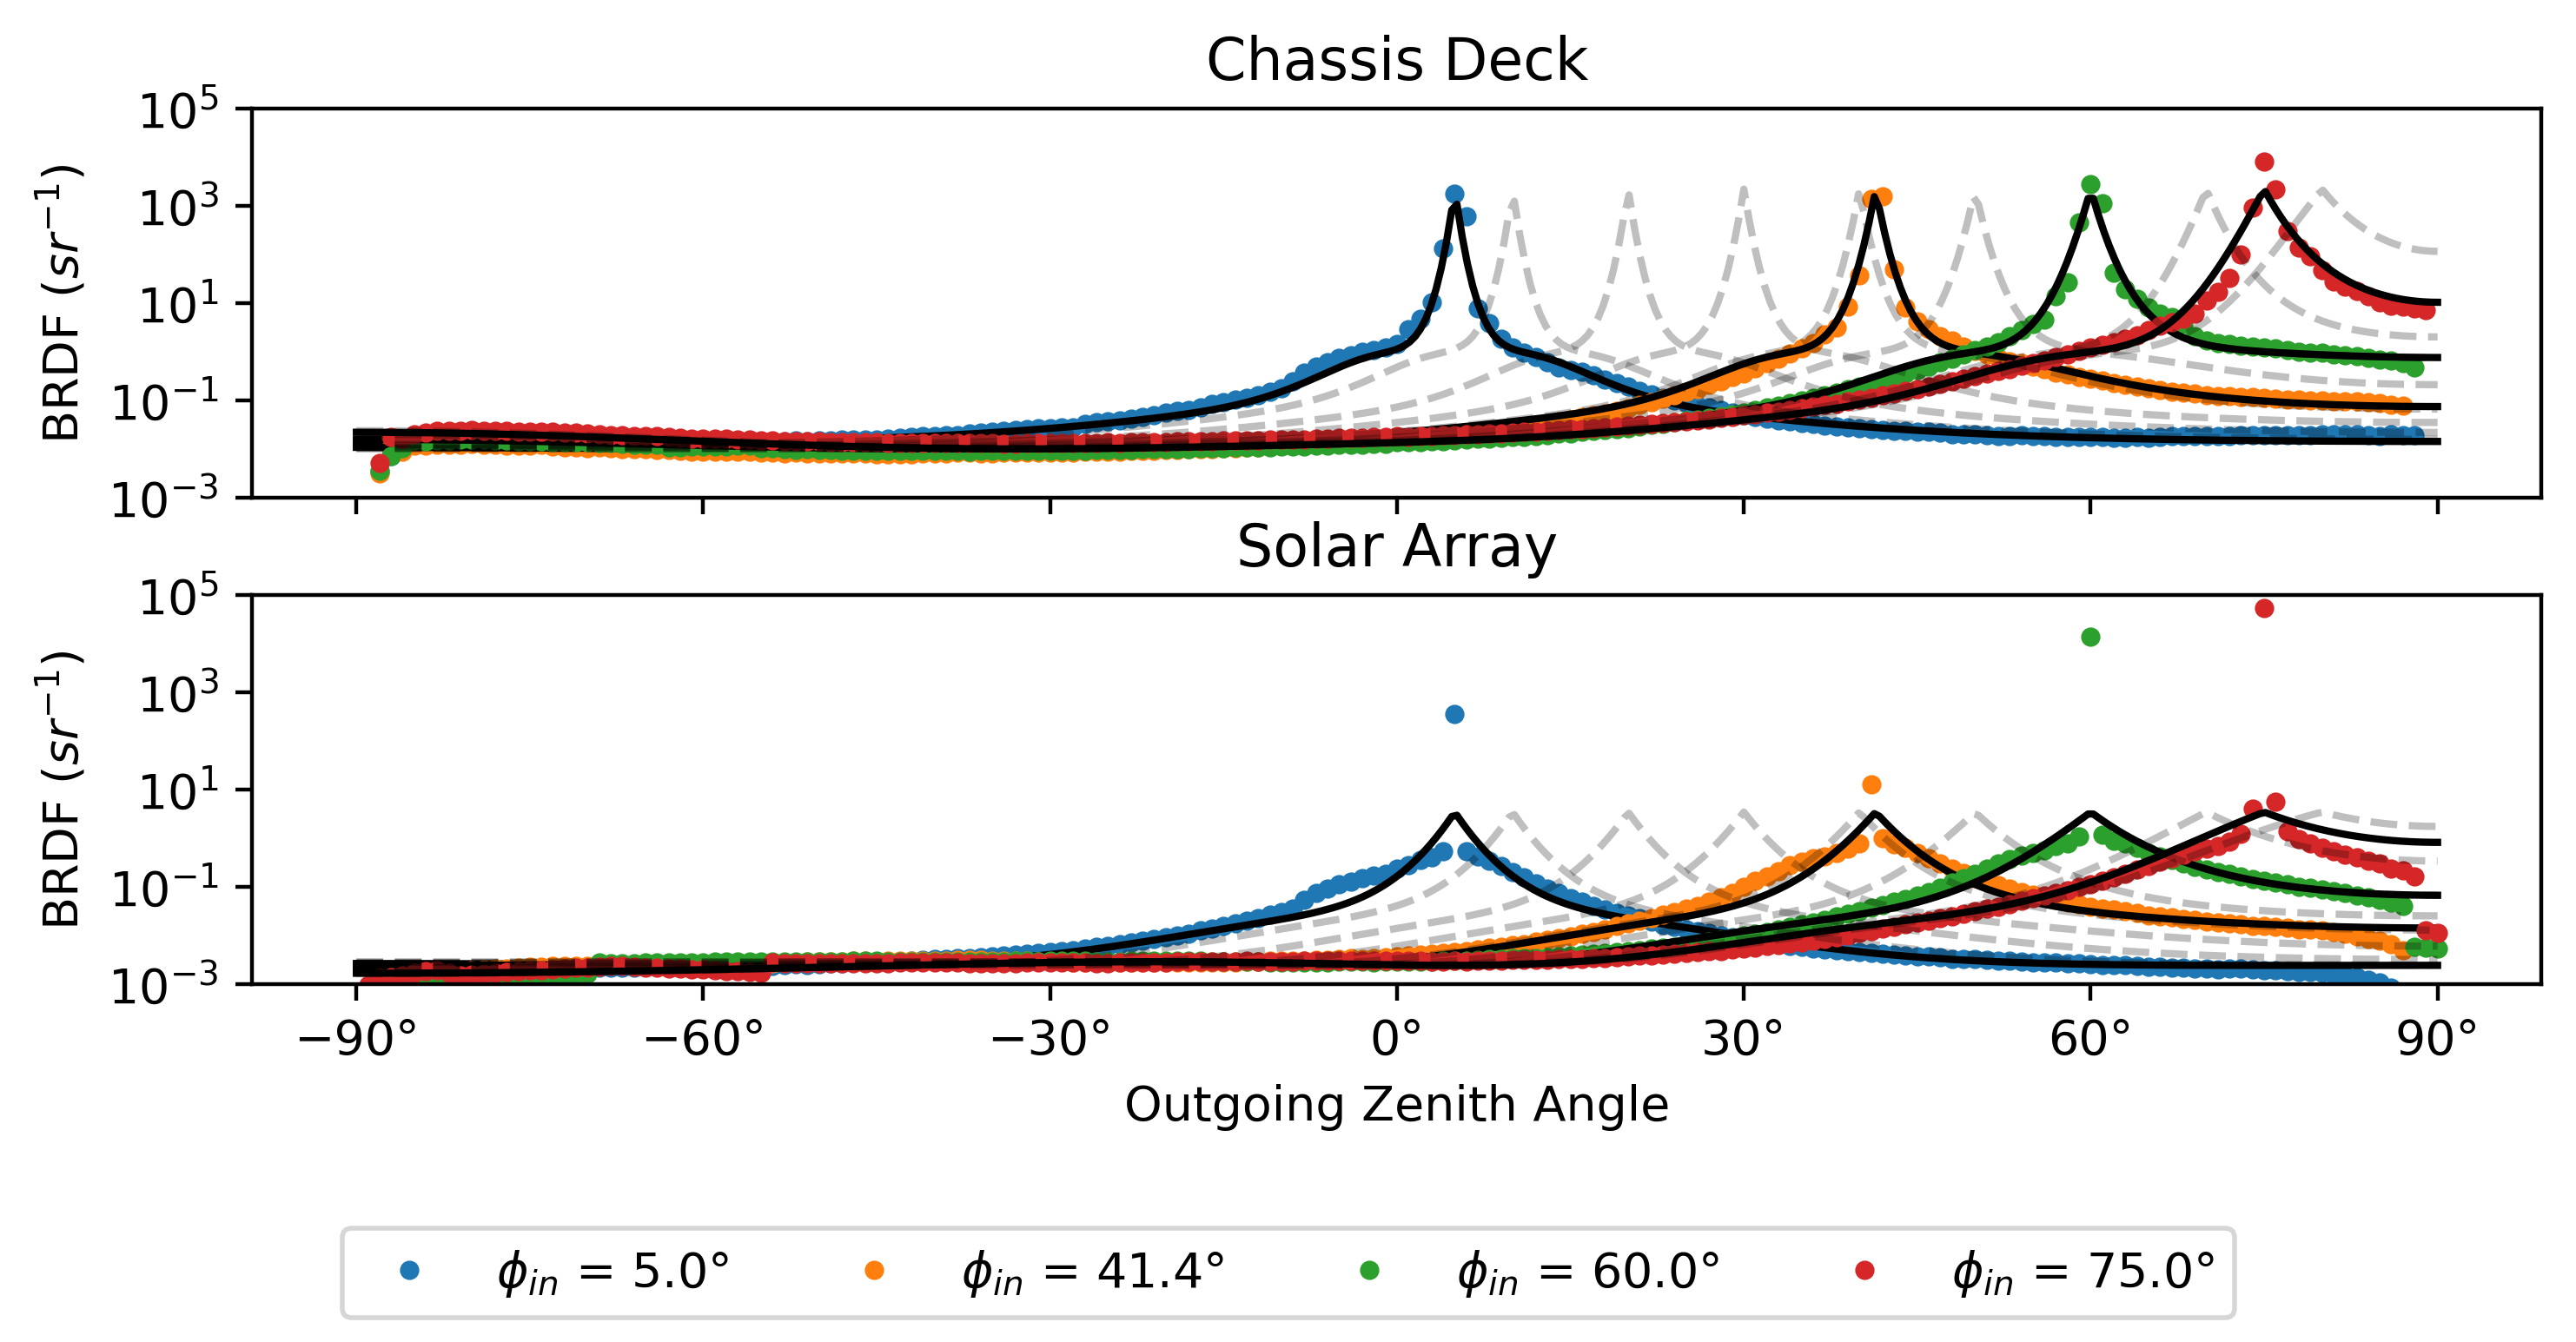

In [6]:
fig, axs = plt.subplots(figsize = (8.5, 4), nrows = 2, ncols = 1, sharex = True, dpi = 400)

plot_fit(axs[0], chassis_brdf, "../data/chassis_brdf.csv")
axs[0].set_title("Chassis Deck")

plot_fit(axs[1], solar_array_brdf, "../data/solar_array_brdf.csv")
axs[1].set_title("Solar Array")

for ax in axs:
    ax.set_ylim(10e-4, 10e4)
    ax.set_ylabel(r"BRDF ($sr^{-1}$)")

axs[1].set_xlabel("Outgoing Zenith Angle")
axs[1].set_xticks([-90, -60, -30, 0, 30, 60, 90])
axs[1].xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 4, loc = 'lower center')
fig.subplots_adjust(bottom = 0.25, hspace = 0.25)

plt.show()

### Fitting BRDFs to CARs Measurements

In [7]:
def phong_fit(data_file):

    def model(*params):
        Kd, Ks, n = params
        brdf = lumos.brdf.library.PHONG(Kd, Ks, n)
        return brdf
    
    Kd, Ks, n = lumos.brdf.tools.fit(data_file, model, p0 = (1, 1, 1), bounds = (0, 200))
    return Kd, Ks, n


In [8]:
Kd, Ks, n = phong_fit("../data/vegetation_brdf_cars.csv")
Kd, Ks, n = round(Kd, 2), round(Ks, 2), round(n, 2)

print("--------------------------------")
print("Vegetation BRDF")
print(f"{Kd = }, {Ks = }, {n = }")
print("--------------------------------")

Kd, Ks, n = phong_fit("../data/water_brdf_cars.csv")
Kd, Ks, n = round(Kd, 2), round(Ks, 2), round(n, 2)

print("Ocean Water BRDF")
print(f"{Kd = }, {Ks = }, {n = }")
print("--------------------------------")


--------------------------------
Vegetation BRDF
Kd = np.float64(0.53), Ks = np.float64(0.28), n = np.float64(7.31)
--------------------------------
Ocean Water BRDF
Kd = np.float64(0.48), Ks = np.float64(0.08), n = np.float64(16.45)
--------------------------------
